In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [45]:
!ls ../fcn8s/10x/snapshots

checkpoint			    fcn.ckpt-49800.data-00000-of-00001
fcn.ckpt-12450.data-00000-of-00001  fcn.ckpt-49800.index
fcn.ckpt-12450.index		    fcn.ckpt-49800.meta
fcn.ckpt-12450.meta		    fcn.ckpt-53950.data-00000-of-00001
fcn.ckpt-16600.data-00000-of-00001  fcn.ckpt-53950.index
fcn.ckpt-16600.index		    fcn.ckpt-53950.meta
fcn.ckpt-16600.meta		    fcn.ckpt-58100.data-00000-of-00001
fcn.ckpt-20750.data-00000-of-00001  fcn.ckpt-58100.index
fcn.ckpt-20750.index		    fcn.ckpt-58100.meta
fcn.ckpt-20750.meta		    fcn.ckpt-62250.data-00000-of-00001
fcn.ckpt-24900.data-00000-of-00001  fcn.ckpt-62250.index
fcn.ckpt-24900.index		    fcn.ckpt-62250.meta
fcn.ckpt-24900.meta		    fcn.ckpt-66400.data-00000-of-00001
fcn.ckpt-29050.data-00000-of-00001  fcn.ckpt-66400.index
fcn.ckpt-29050.index		    fcn.ckpt-66400.meta
fcn.ckpt-29050.meta		    fcn.ckpt-70550.data-00000-of-00001
fcn.ckpt-33200.data-00000-of-00001  fcn.ckpt-70550.index
fcn.ckpt-33200.index		    fcn.ckpt-70550.meta
fcn.ckpt-33200.meta		    fcn.c

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '../fcn8s')
from fcn8s import Inference

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from MulticoreTSNE import MulticoreTSNE as MTSNE

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [2]:
# SNAPSHOT = '../fcn8s/5x/snapshots/fcn.ckpt-13500'
SNAPSHOT = '../fcn8s/10x/snapshots/fcn.ckpt-82585'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Inference(sess=sess, x_dims = [256, 256, 3])
model.restore(SNAPSHOT)

Setting up fcn in inference mode
FCN Model
Non-linearity: <function selu at 0x7f82fbac7de8>
	 x_in (?, 256, 256, 3)
	 c0_pool (?, 128, 128, 32)
	 c1_pool (?, 64, 64, 64)
	 c2_pool (?, 32, 32, 128)
	 c3_pool (?, 16, 16, 128)
	 c4_pool (?, 8, 8, 256)
	 fc_1 (?, 1, 1, 2048)
	 fc_2 (?, 1, 1, 2048)
	 score_fr (?, 1, 1, 5)
	 prediction_3 (?, 16, 16, 5)
	 prediction_2 (?, 32, 32, 5)
	 prediction_1 (?, 64, 64, 5)
	 prediction_0 (?, 128, 128, 5)
	 upscore3 (?, 16, 16, 5)
	 upscore3_fuse (?, 16, 16, 5)
	 upscore2 (?, 32, 32, 5)
	 upscore2_fuse (?, 32, 32, 5)
	 upscore1 (?, 64, 64, 5)
	 upscore1_fuse (?, 64, 64, 5)
	 upscore0 (?, 128, 128, 5)
	 upscore0_fuse (?, 128, 128, 5)
	 y_hat (?, 256, 256, 5)
Model output y_hat: (?, 256, 256, 5)
Restoring from ../fcn8s/10x/snapshots/fcn.ckpt-82585
INFO:tensorflow:Restoring parameters from ../fcn8s/10x/snapshots/fcn.ckpt-82585
Success!


In [11]:
jpg_list = sorted(glob.glob('../data/val_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask/*.png'))

img_classes = []
orig_imgs = []

z1_vectors = []
z2_vectors = []
z3_vectors = []
idx = 0

samples = 10
x0_vect = np.linspace(0, 1200-512, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-512, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
    for x0, y0 in coords:
        x0 = np.random.randint(0, 1200-512)
        y0 = np.random.randint(0, 1200-512)
        
        ## Grab the majority label
        y_ = y[x0:x0+512, y0:y0+512]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (512**2):
            img_classes.append(maj)
            orig_imgs.append(img_idx)
            idx += 1
            if idx % 250 == 0:
                print(idx, x0, y0)
        
        else:
            continue

        x_ = x[x0:x0+512, y0:y0+512, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=0.5, fy=0.5)
        x_ = x_ * (2/255.) - 1.
        x_ = np.expand_dims(x_, 0)

        
        z1, z2, z3 = sess.run([model.bottleneck_1, model.bottleneck_2, model.bottleneck_3], 
                          feed_dict={model.x_in: x_, model.keep_prob: 1.0})

        ## Collapse z on the spatial dimensions:
        z1_ = np.mean(z1, axis=(1,2))
        z2_ = np.mean(z2, axis=(1,2))
        z3_ = np.mean(z3, axis=(1,2))
        z1_vectors.append(z1_)
        z2_vectors.append(z2_)
        z3_vectors.append(z3_)
    
    
z1_vectors = np.concatenate(z1_vectors, axis=0)
z2_vectors = np.concatenate(z2_vectors, axis=0)
z3_vectors = np.concatenate(z3_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print(z1_vectors.shape)
print(z2_vectors.shape)
print(z3_vectors.shape)

250 583 262
500 229 509
750 405 516
1000 297 464
(1194, 2048)
(1194, 2048)
(1194, 5)


(1194, 2)


Text(0.5,1,'FCN Bottleneck layer embedding')

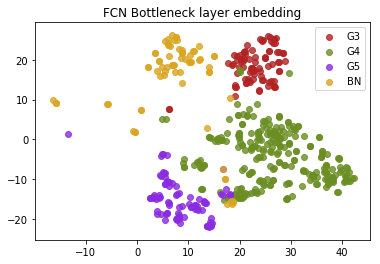

In [12]:
manifold = MTSNE(n_jobs=12, n_components=2)
# manifold = PCA(n_components=2)
z1_manifold = manifold.fit_transform(z1_vectors)
print(z1_manifold.shape)

for k in range(4):
    idxs = np.where(img_classes==k)
    sns.regplot(z1_manifold[idxs,0], z1_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k])

plt.legend()
plt.title('FCN Bottleneck layer embedding')

(1194, 2)


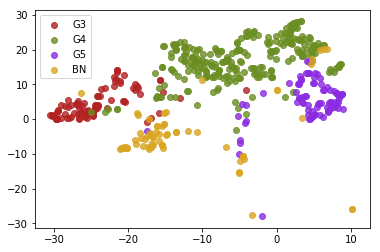

In [15]:
# manifold = TSNE(n_components=2)
manifold = MTSNE(n_jobs=12, n_components=2)
# manifold = PCA(n_components=2)
z2_manifold = manifold.fit_transform(z2_vectors)
print(z2_manifold.shape)

for k in range(4):
    idxs = np.where(img_classes==k)
    sns.regplot(z2_manifold[idxs,0], z2_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k])

plt.legend()

(1194, 2)


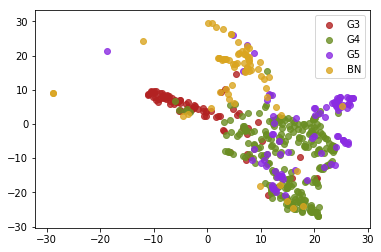

In [16]:
# manifold = TSNE(n_components=2)
manifold = MTSNE(n_jobs=12, n_components=2)
# manifold = PCA(n_components=2)
z3_manifold = manifold.fit_transform(z3_vectors)
print(z3_manifold.shape)

for k in range(4):
    idxs = np.where(img_classes==k)
    sns.regplot(z3_manifold[idxs,0], z3_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k])

plt.legend()

## Clustermaps

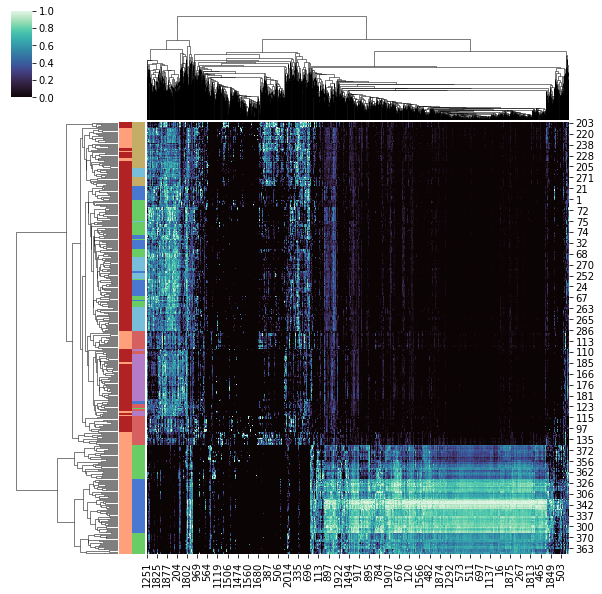

In [41]:
row_colors = [colors[k] for k in img_classes]
palette2 = sns.color_palette("muted", n_colors=len(np.unique(orig_imgs)))
row_colors2 = [palette2[k] for k in orig_imgs]

sns.clustermap(z1_vectors, standard_scale=1, cmap='mako', row_colors=[row_colors, row_colors2])

ValueError: The condensed distance matrix must contain only finite values.

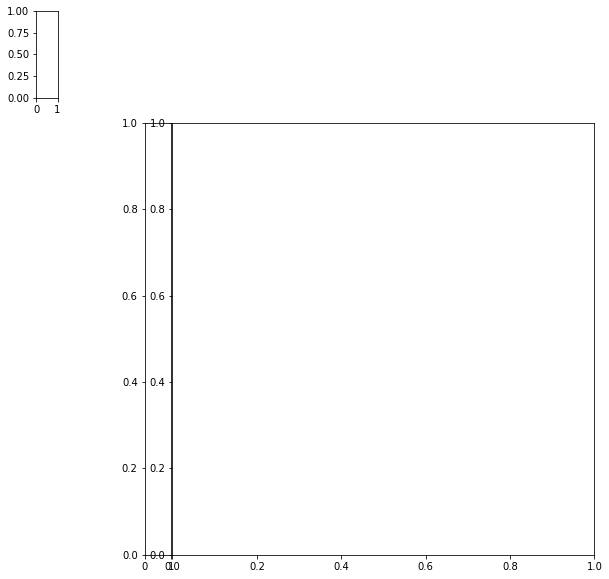

In [42]:
row_colors = [colors[k] for k in img_classes]
palette2 = sns.color_palette("muted", n_colors=len(np.unique(orig_imgs)))
row_colors2 = [palette2[k] for k in orig_imgs]

sns.clustermap(z2_vectors, standard_scale=1, cmap='mako', row_colors=[row_colors, row_colors2])

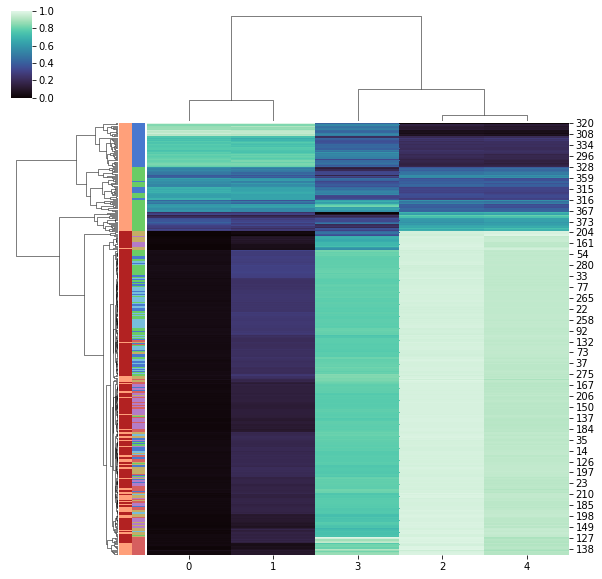

In [43]:
row_colors = [colors[k] for k in img_classes]
palette2 = sns.color_palette("muted", n_colors=len(np.unique(orig_imgs)))
row_colors2 = [palette2[k] for k in orig_imgs]

sns.clustermap(z3_vectors, standard_scale=1, cmap='mako', row_colors=[row_colors, row_colors2])

## Single images; close to x-space

In [5]:
jpg_list = sorted(glob.glob('../data/val_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask/*.png'))

x0 = 128
y0 = 128
z1_flat = np.empty(shape=(1,32))
z2_flat = np.empty(shape=(1,5))
y_flat = np.empty(shape=(1,1), dtype=np.int)
n = 10

imgs = zip(jpg_list, mask_list)
np.random.shuffle(imgs)

for jpg, mask in imgs[:n]:

    x = cv2.imread(jpg, -1)[:,:,::-1]
    y = cv2.imread(mask, -1)
    y_ = y[x0:x0+512, y0:y0+512]
    x_ = x[x0:x0+512, y0:y0+512]
    x_ = cv2.resize(x_, dsize=(0,0), fx=0.5, fy=0.5)
    x_ = x_ * (2/255.) - 1.
    x_ = np.expand_dims(x_, 0)

    z1, z2 = sess.run([model.conv_1, model.preout], feed_dict={model.x_in: x_, model.keep_prob: 1.0})

#     z1 = np.squeeze(z1)
#     z2 = np.squeeze(z2)

    z1_flat = np.concatenate([z1_flat, z1.reshape(128*128, 32)], axis=0)
    z2_flat = np.concatenate([z2_flat, z2.reshape(128*128, 5)], axis=0)

    y_ = cv2.resize(y_, dsize=(128, 128), interpolation=cv2.INTER_NEAREST).reshape(128*128, 1).astype(np.int)
    y_flat = np.concatenate([y_flat, y_], axis=0)
    
print(z1_flat.shape)
print(z2_flat.shape)
print(y_flat.shape)
print(np.unique(y_flat))

# img_classes = np.squeeze(img_classes)

(163841, 32)
(163841, 5)
(163841, 1)
[0 1 2 3 4]


In [6]:
x1 = np.empty((0,32))
x2 = np.empty((0,5))
y = []
n_sample = 100
for k in range(5):
    z1_class = z1_flat[np.squeeze(y_flat)==k, :]
    z2_class = z2_flat[np.squeeze(y_flat)==k, :]
    
    n_z = z1_class.shape[0]
    print(k, n_z)
    
    idxs = np.arange(n_z)
    z1_choice = z1_class[np.random.choice(idxs, 500), :]
    z2_choice = z2_class[np.random.choice(idxs, 500), :]
    x1 = np.concatenate([x1, z1_choice], axis=0)
    x2 = np.concatenate([x2, z2_choice], axis=0)
    y += [k]*500
    
y = np.asarray(y, dtype=np.int)
print('y unique', np.unique(y))
print('y shape', y.shape)
print('x1 shape', x1.shape)
print('x2 shape', x2.shape)

manifold = MTSNE(n_components=3, n_jobs=12)
# manifold = PCA(n_components=3)
pr1 = manifold.fit_transform(x1)
print('pr1 shape', pr1.shape)

pr2 = manifold.fit_transform(x2)
print('pr2 shape', pr2.shape)

0 7508
1 26377
2 30125
3 480
4 99351
y unique [0 1 2 3 4]
y shape (2500,)
x1 shape (2500, 32)
x2 shape (2500, 5)
pr1 shape (2500, 3)
pr2 shape (2500, 3)


Text(0.5,0.92,'Convoluted first layer (TSNE)')

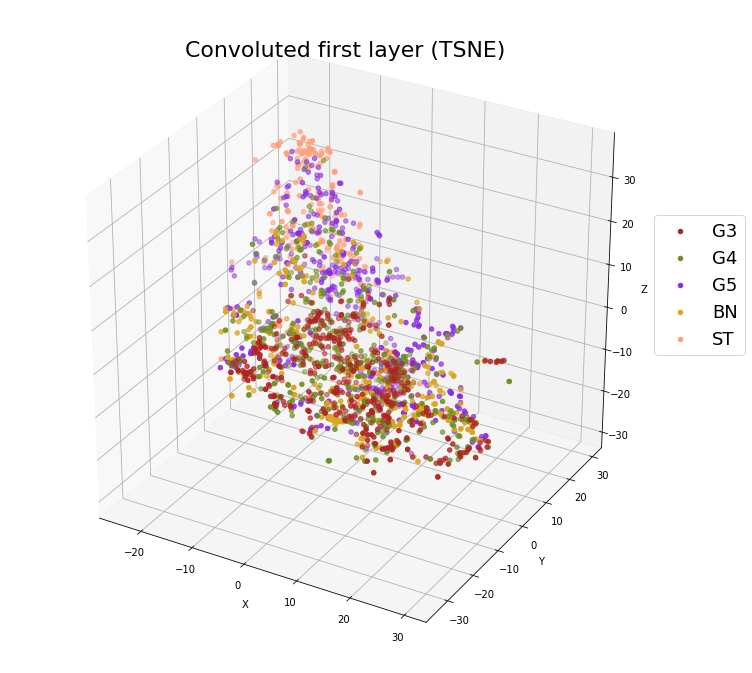

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr1[idxs, 0]
    ys = pr1[idxs, 1]
    zs = pr1[idxs, 2]
    ax.scatter(xs, ys, zs, color=colors[k], label=labels[k])
#         sns.regplot(pr[idxs,0], pr[idxs,1], pr[idx,2], fit_reg=False, color=colors[k], label=labels[k], ax=ax)
        
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend(bbox_to_anchor=(1.11, 0.7), fontsize=18)
plt.title('Convoluted first layer (TSNE)', fontsize=22)

Text(0.5,0.98,'First Layer TSNE')

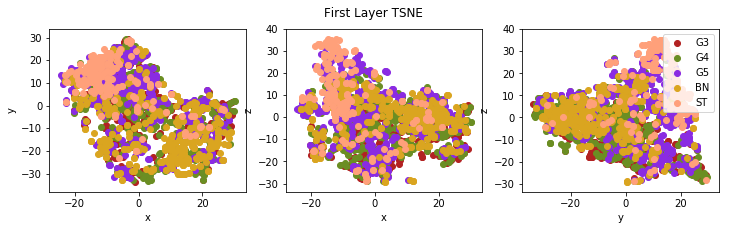

In [8]:
fig, axs = plt.subplots(1,3, figsize=(12,3))

for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr1[idxs, 0]
    ys = pr1[idxs, 1]
    axs[0].scatter(xs, ys, color=colors[k], label=labels[k])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
    
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr1[idxs, 0]
    zs = pr1[idxs, 2]
    axs[1].scatter(xs, zs, color=colors[k], label=labels[k])
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
    
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    ys = pr1[idxs, 1]
    zs = pr1[idxs, 2]
    axs[2].scatter(ys, zs, color=colors[k], label=labels[k])
axs[2].set_xlabel('y')
axs[2].set_ylabel('z')
    
plt.legend()
plt.suptitle('First Layer TSNE')

(500,)
(500,)
(500,)
(500,)
(500,)


Text(0.5,0.92,'Linearly separable final layer (TSNE)')

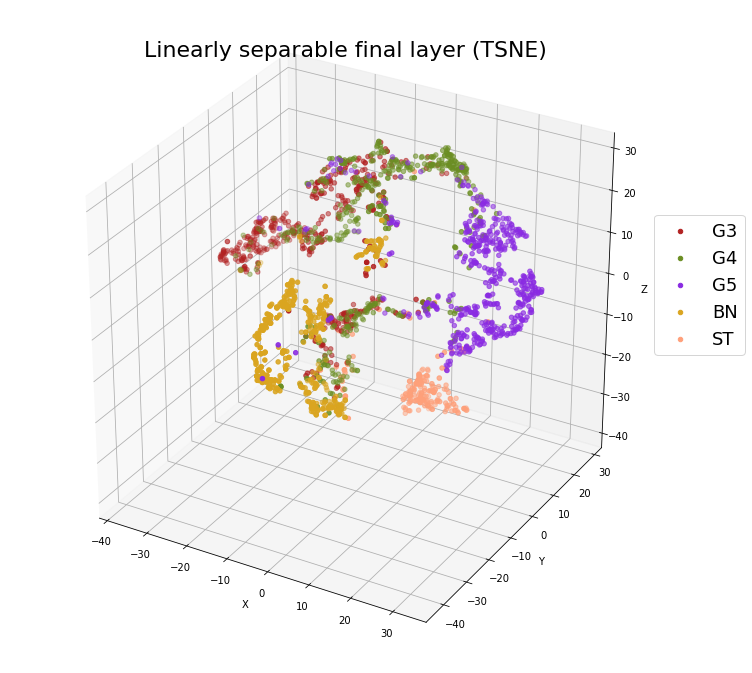

In [9]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    print(idxs.shape)
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr2[idxs, 0]
    ys = pr2[idxs, 1]
    zs = pr2[idxs, 2]
    ax.scatter(xs, ys, zs, color=colors[k], label=labels[k])
#         sns.regplot(pr[idxs,0], pr[idxs,1], pr[idx,2], fit_reg=False, color=colors[k], label=labels[k], ax=ax)
        
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend(bbox_to_anchor=(1.11, 0.7), fontsize=18)
plt.title('Linearly separable final layer (TSNE)', fontsize=22)

Text(0.5,0.98,'Last Layer TSNE')

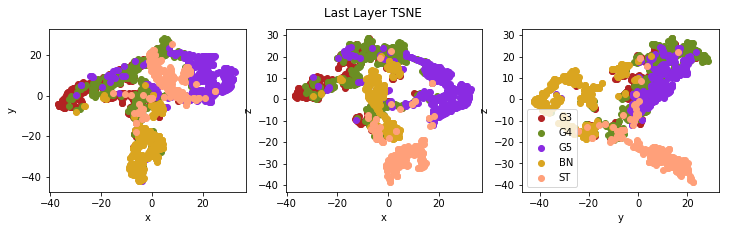

In [10]:
fig, axs = plt.subplots(1,3, figsize=(12,3))

for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr2[idxs, 0]
    ys = pr2[idxs, 1]
    axs[0].scatter(xs, ys, color=colors[k], label=labels[k])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
    
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs = pr2[idxs, 0]
    zs = pr2[idxs, 2]
    axs[1].scatter(xs, zs, color=colors[k], label=labels[k])
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
    
for k in range(5):
    idxs = np.squeeze(np.where(y==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    ys = pr2[idxs, 1]
    zs = pr2[idxs, 2]
    axs[2].scatter(ys, zs, color=colors[k], label=labels[k])
axs[2].set_xlabel('y')
axs[2].set_ylabel('z')
    
plt.legend()
plt.suptitle('Last Layer TSNE')